# DETECTION OF KEY POINTS ON THE FACE

### Introcution
This notewook show the process to creatre a Convolutional Neural Network, wich detect the key point to a face image. To create the CNN I am using Pytorch. 

### Image database
This set of image data has been extracted from the [YouTube Faces Dataset](https://www.cs.tau.ac.il/~wolf/ytfaces/), which includes videos of people in YouTube videos. These videos have been fed through some processing steps and turned into sets of image frames containing one face and the associated keypoints. In this case the whole database is in a zip folder and we extract the files without unzipping the zip file.

## Start the process


Import the libraries

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torch.nn as nn
import torch.nn.functional as F

Import CSV files with images key points and name

In [2]:
#zip folder with all files
zf = ZipFile("train-test-data.zip") 

#CSV files 
csvtr = pd.read_csv(zf.open('training_frames_keypoints.csv'))
csvtr = pd.DataFrame.to_numpy(csvtr)

csvte = pd.read_csv(zf.open('test_frames_keypoints.csv'))
csvte = pd.DataFrame.to_numpy(csvte)

Examples to images and her key points

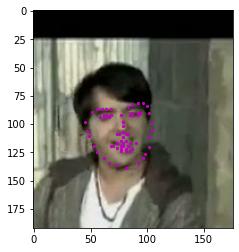

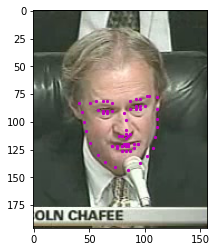

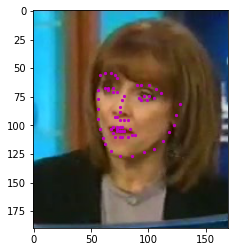

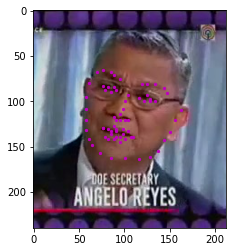

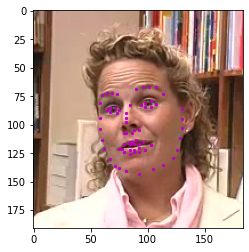

In [3]:
for i in range(5):
    
    kp = csvtr[i][1:] #key points array
    kp_matrix = kp.astype('float').reshape(-1, 2)
    im_name = csvtr[i][0] 
    
    imag = mpimg.imread( zf.open('training/'+im_name) )
    im_copy = cv2.cvtColor(np.copy(imag), cv2.COLOR_RGB2GRAY)
    
    plt.imshow(imag)
    plt.scatter(kp_matrix[:, 0], kp_matrix[:, 1], s=20, marker='.', c='m')
    plt.show()
    plt.close()

This CNN will detect the face key poits to only 1 person, for this reason we will train the model before detect the face with Haar Cascade classifiers. 

## Detect the faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

The functions that was used to tranform the face images to arrays [1,224,224]

In [4]:
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

##Haar Cascade function
def cascade_modify1(image, key_points): #image BGR, Key points
    
    #image processing and key point array processing   
    imag2 = image.copy()
    imag2 = cv2.cvtColor(imag2, cv2.COLOR_BGR2GRAY) 
    imag2 = np.array(imag2*255, dtype='uint8') # To use Cascade the array values should be a int values
    
    key_points = key_points.astype('float').reshape(-1, 2)
     
    # load in a haar cascade classifier for detecting frontal faces
    faces = face_cascade.detectMultiScale(imag2)
    # make a copy of the original image to plot detections on
    image_with_detections = image.copy()

    # loop over the detected faces, mark the image where each face is found
    cont1 = 0
    for (x,y,w,h) in faces:
        
        #we know that is only 1 face per image but sometimes the algorithm detect more than 1 or 2 times the same,
        #to solve this I include this conditional
        if (x < np.average(key_points[:, 0]) < x+w) & (y < np.average(key_points[:, 1]) < y+h) & (cont1 == 0):
            # define an image contour and cut the face, if the contour is negatve the line is 0
            cont_x = int(w*0.25)
            if x-cont_x < 0: cont_x = x
            cont_y = int(h*0.25)
            if y-cont_y < 0: cont_y = y
             
            image_with_detections = image_with_detections[y-cont_y:y+h+cont_y, x-cont_x:x+w+cont_x]
            

            # new position to key points after cut the face area
            
            key_points[:, 0] = key_points[:, 0]-x+cont_x
            key_points[:, 1] = key_points[:, 1]-y+cont_y
            

            cont1 += 1
        
    
    if cont1 == 0: #If no faces are detected we send the whole image and key points without change.
        
        image_with_detections = image
        
    #flaten the Key points
    key_points = key_points.flatten()
    
    return image_with_detections, key_points, cont1
 

# resize the image and key points
def resize(image, key_points, output_size = 250):
    
    if image.shape != (output_size, output_size):
        x = image.shape[0]
        y = image.shape[1]
        
        # resizethe image
        image = cv2.resize( image,(output_size, output_size) )
        #resize key points
        key_points = key_points.astype('float').reshape(-1, 2)
        key_points[:, 0] = key_points[:, 0]*output_size/x
        key_points[:, 1] = key_points[:, 1]*output_size/y
        #flatten de key point array
        key_points = key_points.flatten()
        
        
    return image, key_points
# normalize the image and key points values       
def normalize(image, key_points):
    
    if np.max(image) >1:
        image = image/255.0
    
    key_pointsy = (key_points-100.0)/50.0
    
    return image, key_pointsy
#move the image, now the face is not in the center
def RandomCrop(image, key_points, output_size = 224): #This function was reused to Udacity Coumputer Vision Micromaster
    
    h, w = image.shape[:2]
    new_h = new_w = output_size

    top = np.random.randint(0, h - new_h)
    left = np.random.randint(0, w - new_w)

    image = image[top: top + new_h,
                  left: left + new_w]

    key_points = key_points.astype('float').reshape(-1, 2)
    key_points = key_points - [left, top]
    key_points = key_points.flatten()
    
    return image, key_points

### Create the treining and test Dataset with the images and her key points

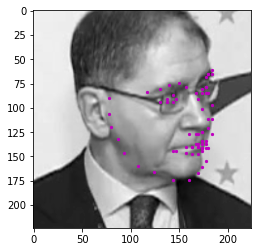

In [5]:
#Test DS
images_training = []
points = []
cont_im = 0
for i in csvtr:
    cont_im += 1 #image counter
    #key points array
    kp = i[1:]
    kp_copy = np.copy(kp)
    #image array
    im_name = i[0]
    image_or = mpimg.imread( zf.open('training/'+im_name) )
    
    im_co = cv2.cvtColor(np.copy(image_or), cv2.COLOR_RGB2GRAY)
    

    imag = image_or.copy()
    #Face image and news key points
    imag, kp_copy, cont1 = cascade_modify1(imag, kp_copy)

    im_copy = cv2.cvtColor(np.copy(imag), cv2.COLOR_RGB2GRAY)
    
    #reshape image and key points
    
    im_copy, kp_copy = resize(im_copy, kp_copy)
    
    # Make randome changes in the image
    im_copy, kp_copy = RandomCrop(im_copy, kp_copy)
    
    
    #Normalice images and the key points arrays
    im_copy, kp_copy = normalize(im_copy, kp_copy) 

    images_training.append( (torch.tensor(im_copy.reshape(1,im_copy.shape[1],im_copy.shape[1])), torch.tensor(kp_copy) ) )
    
    b = "Image number: " + str(cont_im) + ' | percentage of imported images: ' + str(int(100*cont_im/len(csvtr))) + '%'
    print (b, end="\r")
    #print(carp, cont)

#Show the last image
plt.imshow(im_copy, cmap='gray')
kp_matrix = (kp_copy.astype('float')*50+100).reshape(-1, 2)
plt.scatter(kp_matrix[:, 0], kp_matrix[:, 1], s=20, marker='.', c='m')
plt.show()
plt.close()    

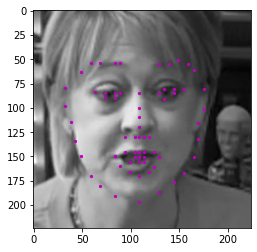

In [6]:
#Test DS
images_test = []
points = []
cont_im = 0
for i in csvte:
    cont_im += 1 #image counter
    #key points array
    kp = i[1:]
    kp_copy = np.copy(kp)
    #image array
    im_name = i[0]
    image_or = mpimg.imread( zf.open('test/'+im_name) )
    
    im_co = cv2.cvtColor(np.copy(image_or), cv2.COLOR_RGB2GRAY)
     

    imag = image_or.copy()
    #Face image and news key points
    imag, kp_copy, cont1 = cascade_modify1(imag, kp_copy)

    im_copy = cv2.cvtColor(np.copy(imag), cv2.COLOR_RGB2GRAY)
    
    #reshape image and key points
    im_copy, kp_copy = resize(im_copy, kp_copy)
    
    # Make randome changes in the image
    im_copy, kp_copy = RandomCrop(im_copy, kp_copy)
    
    
    #Normalice images and the key points arrays
    im_copy, kp_copy = normalize(im_copy, kp_copy) 

    images_test.append( (torch.tensor(im_copy.reshape(1,im_copy.shape[1],im_copy.shape[1])), torch.tensor(kp_copy) ) )
    
    b = "Image number: " + str(cont_im) + ' | percentage of imported images: ' + str(int(100*cont_im/len(csvte))) + '%'
    print (b, end="\r")

#Show the last image
plt.imshow(im_copy, cmap='gray')
kp_matrix = (kp_copy.astype('float')*50+100).reshape(-1, 2)
plt.scatter(kp_matrix[:, 0], kp_matrix[:, 1], s=20, marker='.', c='m')
plt.show()
plt.close()      

Now we need to transform the datasets into a format compatible with the pytorch neural network, and separate the training dataset into batches.

In [7]:
def DFtoDS(df, batch_size):
    DS = DS_training = DataLoader(df,batch_size=batch_size,shuffle=True) 
    return DS

 ## Create the Convolutional Nural Network architecture

In [8]:
#import torch.nn.init as I

class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        
        #Convolutional layers
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 80, 5)
        self.conv3 = nn.Conv2d(80, 190, 3)
        self.conv4 = nn.Conv2d(190, 400, 3)
        
        #####  maxpooling layers #####
        self.maxp1 = nn.MaxPool2d(2, 2)
        self.maxp3 = nn.MaxPool2d(3, 3)
        self.maxp5 = nn.MaxPool2d(5, 5)
        
        ##### Linear Layer #####
        self.linear1 = nn.Linear(25600, 5000)
        self.linear2 = nn.Linear(5000, 136)
        
        ##### Drop out layer #####
        self.drop1 = nn.Dropout(p=0.3)
        
        ##### BatchNorm layer #####
        self.Batch1 = nn.BatchNorm2d(20)
        self.Batch2 = nn.BatchNorm2d(80)
        self.Batch3 = nn.BatchNorm2d(190)
        self.Batch4 = nn.BatchNorm2d(400)

        
    def forward(self, x):

        # x size: [n, 1, 224, 224]
        x = F.relu(self.conv1(x))                 #x.shape = [n, 20, 220, 220]
        x = self.Batch1(x)
        x = self.maxp3(x)                         #x.shape = [n, 20, 73, 73]
        
        x = F.relu(self.conv2(x))                 #x.shape = [n, 80, 69, 69]
        x = self.Batch2(x)
        x = self.maxp3(x)                         #x.shape = [n, 80, 23, 23]
        
        x = nn.Dropout2d(p=0.25)(x)
        
        x = F.relu(self.conv3(x))                 #x.shape = [n, 190, 21, 21]
        x = self.Batch3(x)
        x = self.maxp1(x)                         #x.shape = [n, 190, 10, 10]
        
        #x = nn.Dropout2d(p=0.25)(x)
        
        x = F.relu(self.conv4(x))                 #x.shape = [n, 400, 8, 8]
        x = self.Batch4(x)
        ##x = self.maxp3(x) #[200, 10, 10]
        
        x = x.view(x.size(0), -1)                 #x.shape = [n, 1, 25600]
        
        x = self.drop1(F.relu(self.linear1(x)))   #x.shape = [n, 1, 5000]
        x = self.linear2(x)                       #x.shape = [n, 1, 136]
       
        return x
'''    
arr_t = torch.randn(1,1,224,224)
net = Net()
res_t = net(arr_t)
print(res_t.shape)
'''

'    \narr_t = torch.randn(1,1,224,224)\nnet = Net()\nres_t = net(arr_t)\nprint(res_t.shape)\n'

#### Device and hyperparameters

In [10]:
device = 'cuda'
#device = 'cpu'
batch_size = 13

display_step = 20 #Number of batchs to calculate the mean loss value with train and test images

#### Call the convolutional Neural Network, loss function, optimizer and weights

In [29]:
cnn = CNN().to(device)

#criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()

#optimizer = torch.optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.0001, betas=(0.9, 0.999))


#inicialice the weight
def weights_init(m):
    if isinstance(m, nn.Conv2d) :
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
cnn = cnn.apply(weights_init)


In [30]:
cnn

CNN(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 80, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(80, 190, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(190, 400, kernel_size=(3, 3), stride=(1, 1))
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxp3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (maxp5): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=25600, out_features=5000, bias=True)
  (linear2): Linear(in_features=5000, out_features=136, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (Batch1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Batch2): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Batch3): BatchNorm2d(190, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Batch4): BatchNorm2d(400, eps=1e-0

#### Create the Datasets

In [31]:
DS_training = DFtoDS( images_training, batch_size=batch_size)
DS_test = DFtoDS( images_test, batch_size=10)

In [32]:
print( torch.cuda.memory_allocated() )
print( torch.cuda.memory_reserved() )

1755983872
3992977408


## Training the CNN


Epoch: 1 Avg. train Loss: 0.0066 Avg. test Loss: 0.0134 Best model avg. loss: 0.0134



Epoch: 2 Avg. train Loss: 0.0104 Avg. test Loss: 0.012 Best model avg. loss: 0.0081



Epoch: 3 Avg. train Loss: 0.0005 Avg. test Loss: 0.0102 Best model avg. loss: 0.0069



Epoch: 4 Avg. train Loss: 0.0065 Avg. test Loss: 0.0084 Best model avg. loss: 0.0064



Epoch: 5 Avg. train Loss: 0.0065 Avg. test Loss: 0.0073 Best model avg. loss: 0.0055



Epoch: 6 Avg. train Loss: 0.0005 Avg. test Loss: 0.0043 Best model avg. loss: 0.0043



Epoch: 7 Avg. train Loss: 0.0026 Avg. test Loss: 0.0065 Best model avg. loss: 0.0043



Epoch: 8 Avg. train Loss: 0.004 Avg. test Loss: 0.0094 Best model avg. loss: 0.0034



Epoch: 9 Avg. train Loss: 0.0006 Avg. test Loss: 0.0059 Best model avg. loss: 0.0033



Epoch: 10 Avg. train Loss: 0.0021 Avg. test Loss: 0.0045 Best model avg. loss: 0.0033



Epoch: 11 Avg. train Loss: 0.0035 Avg. test Loss: 0.0043 Best model avg. loss: 0.0029



Epoch: 12 Avg. train Loss: 0.0008 Avg. test Loss: 0.0036 Best model avg. loss: 0.0023



Epoch: 13 Avg. train Loss: 0.0019 Avg. test Loss: 0.0035 Best model avg. loss: 0.0023



Epoch: 14 Avg. train Loss: 0.0029 Avg. test Loss: 0.0032 Best model avg. loss: 0.002



Epoch: 15 Avg. train Loss: 0.0008 Avg. test Loss: 0.0025 Best model avg. loss: 0.002



Epoch: 16 Avg. train Loss: 0.0019 Avg. test Loss: 0.0034 Best model avg. loss: 0.0019



Epoch: 17 Avg. train Loss: 0.0032 Avg. test Loss: 0.0048 Best model avg. loss: 0.0019



Epoch: 18 Avg. train Loss: 0.0009 Avg. test Loss: 0.002 Best model avg. loss: 0.0016



Epoch: 19 Avg. train Loss: 0.0017 Avg. test Loss: 0.0046 Best model avg. loss: 0.0016



Epoch: 20 Avg. train Loss: 0.0 Avg. test Loss: 0.0026 Best model avg. loss: 0.0016



Epoch: 21 Avg. train Loss: 0.0008 Avg. test Loss: 0.0021 Best model avg. loss: 0.0016



Epoch: 22 Avg. train Loss: 0.002 Avg. test Loss: 0.0031 Best model avg. loss: 0.0015



Epoch: 23 Avg. train Loss: 0.0001 Avg. test Loss: 0.0028 Best model avg. loss: 0.0015



Epoch: 24 Avg. train Loss: 0.0009 Avg. test Loss: 0.0039 Best model avg. loss: 0.0015



Epoch: 25 Avg. train Loss: 0.0017 Avg. test Loss: 0.0035 Best model avg. loss: 0.0015



Epoch: 26 Avg. train Loss: 0.0003 Avg. test Loss: 0.0022 Best model avg. loss: 0.0015



Epoch: 27 Avg. train Loss: 0.001 Avg. test Loss: 0.0023 Best model avg. loss: 0.0013



Epoch: 28 Avg. train Loss: 0.002 Avg. test Loss: 0.0021 Best model avg. loss: 0.0013



Epoch: 29 Avg. train Loss: 0.0002 Avg. test Loss: 0.0016 Best model avg. loss: 0.0013



Epoch: 30 Avg. train Loss: 0.0011 Avg. test Loss: 0.0014 Best model avg. loss: 0.0012
tensor(0.0014, device='cuda:0', grad_fn=<SmoothL1LossBackward>)


Text(0.5, 1.0, 'Evolution of the value of the lost function over time')

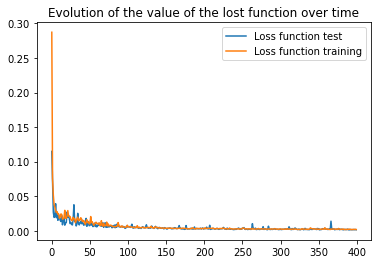

In [33]:
tr_lf = [] #Array with Training loss function evolution
te_lf = [] #Array Test loss function evolution

lf = 0 # Training loss function men value 

count_batch = 0
best_model = 99

n_epochs = 30

for epoch in range(n_epochs):
    for IM, KP in tqdm(DS_training):
        
        count_batch += 1
        
        IM = IM.to(device)  #images training
        KP = KP.to(device)  # key points treining
        
        
        #Update discriminator
        # clear all the gradients
        optimizer.zero_grad()
        KP_pred = cnn(IM)   #The CNN predict the Key Points
        
        loss = criterion(KP_pred.float(), KP.float()) 
        # problem solved by https://discuss.pytorch.org/t/runtimeerror-found-dtype-double-but-expected-float-exception-raised-from-compute-types-at-opt-conda-conda-bld-pytorch-1595629403081-work-aten-src-aten-native-tensoriterator-cpp-183/98499
        
        loss.backward()
        optimizer.step()
        
        lf += loss.item() / display_step #Average loss value
        
        if count_batch == display_step: 
            tr_lf.append( lf ) #Save the average loss value 
            count_batch =0
            lf = 0
            
            lf_te = [] #test loss values
            for _, test in enumerate(DS_test): # start to test the model
                
                IM_test = test[0].to(device)   # test images
                KP_test = test[1].to(device)   # test key points
                KP_test_pred = cnn(IM_test)    # predicted key points
                loss_te = criterion(KP_test_pred.float(), KP_test.float()) #loss value
                lf_te.append( loss.item() )
            lf_te = np.average(lf_te)          #average loss vale 
            te_lf.append(lf_te) 
            
            #Save the model if the loss function with train data is better
            if lf_te < best_model: 
                model_dir = 'models/'
                model_name = 'keypoints_best_model.pt'
                torch.save(cnn.state_dict(), model_dir+model_name)
                best_model = np.median(lf_te)
    
    # Print the results
    avg_train_loss = round(lf, 4)
    avg_test_loss = round(lf_te, 4)
    best_model_loss = round(best_model, 4)

    print('Epoch: '+str(epoch + 1)+' Avg. train Loss: '+str(round(np.average(lf), 4))+' Avg. test Loss: '+str(round(np.median(lf_te), 4))+' Best model avg. loss: '+str(round(best_model, 4)) )           
            
        
print(loss)        
plt.plot(te_lf, label='Loss function test')  
plt.plot(tr_lf, label='Loss function training')
plt.legend()
plt.title('Evolution of the value of the lost function over time')


### Show images predicctions
The model has a loss value of 0.0012, it is a very good, but how is the result in the images?

In [34]:
#print the firsts 5 images to test data set
for _, test in enumerate(DS_test):
                
    IM_test = test[0].to(device)
    KP_test = test[1].numpy()*50 + 100
    KP_test_pred = cnn(IM_test)*50 + 100
    KP_test_pred = KP_test_pred.to('cpu').detach().numpy()
    IM_test = IM_test.to('cpu').numpy()
    
    break
    

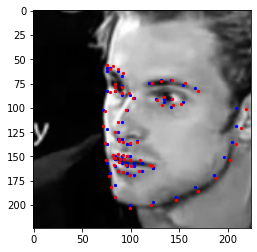

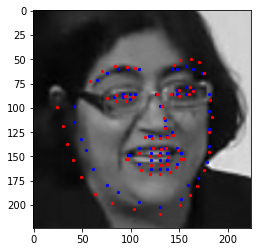

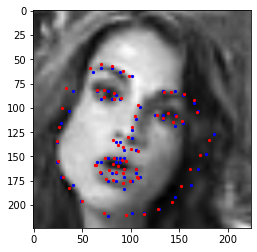

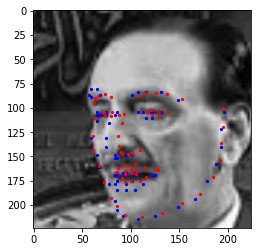

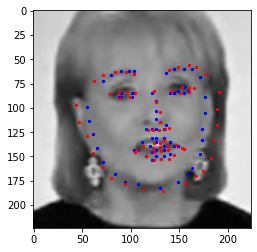

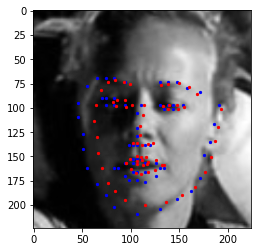

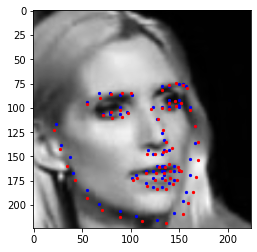

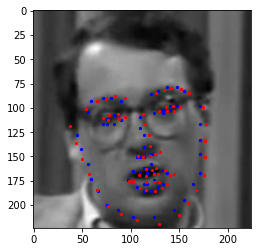

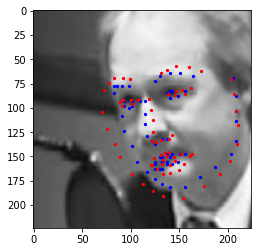

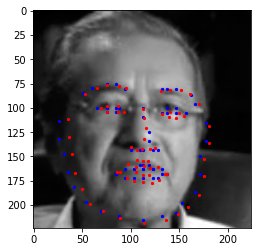

In [35]:
for i in range(IM_test.shape[0]):
    
    #Obtain de image
    image = IM_test[i]*255.0
    #transpose the image
    image = np.transpose(IM_test[i]*255.0, (1, 2, 0) )
    
    #Obtaining real key points and converting them to floats
    real_kp = KP_test[i].astype('float')
    #reshape the array [1,136] to [2,68]
    real_kp = real_kp.reshape(-1, 2)
    
    #Obtaining real key points and converting them to floats
    pred_kp = KP_test_pred[i].astype('float')
    #reshape the array [1,136] to [2,68]
    pred_kp = pred_kp.reshape(-1, 2)
    
    #Show the image with the key points
    plt.imshow(image, cmap='gray')
    plt.scatter(real_kp[:, 0], real_kp[:, 1], s=20, marker='.', c='b')
    plt.scatter(pred_kp[:, 0], pred_kp[:, 1], s=20, marker='.', c='r')
    
    plt.show()
    plt.close()
    
    #real_kp = KP_test

### How does the first convolutional layer work?
It is impossible to know with 100% certainty what a CNN learns with multiple layers, but by applying the first one to the image we can play around trying to understand it.

[[-0.00534408 -0.01084905 -0.00483472  0.01576678  0.02706218]
 [ 0.00123923 -0.04316413 -0.00168193 -0.00189609  0.00579305]
 [-0.04715876  0.01060469  0.01460481 -0.00658632 -0.05737534]
 [-0.02311481 -0.01003158  0.00177357  0.00868487  0.02232745]
 [-0.01859828 -0.0349974  -0.01443116 -0.04273796  0.02325706]]
(5, 5)


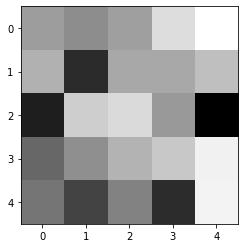

In [36]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
cnn = cnn.to('cpu')
weights1 = cnn.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')

Text(0.5, 1.0, 'Filtred')

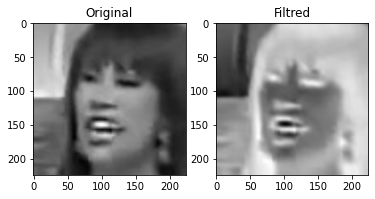

In [37]:
image =images_test[5][0].numpy() # Select  image  and  convert to numpy array from a Tensor
image = image[0,:,:]
#Use cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(image, cmap='gray')
ax1.set_title('Original')


filt_im = cv2.filter2D(image,-1,w[filter_index][0])

ax2.imshow(filt_im, cmap='gray')
ax2.set_title('Filtred')

The filter shown in the graph is to detect dark areas and lighter areas, with extrem values. Normaly the people in this images is iluminated and this filter detect the face areas like a dark areas but the face shadows are white and usually the shadows are consecuence to face features.

## Use the model with other images

I am going to apply this model to a familiar image


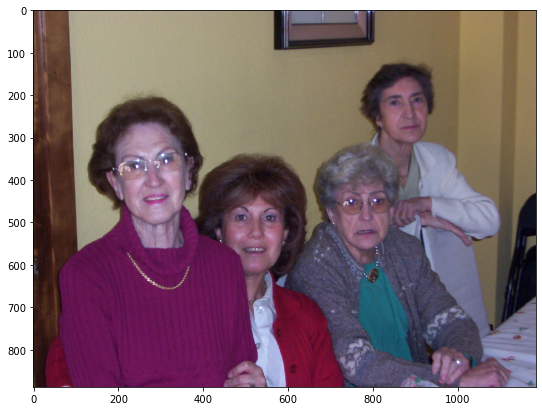

In [38]:
image = cv2.imread('images/meeting.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)
image_copy1 = image.copy()

image_copy = image.copy()
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)

The first function is apply cascade face detecction

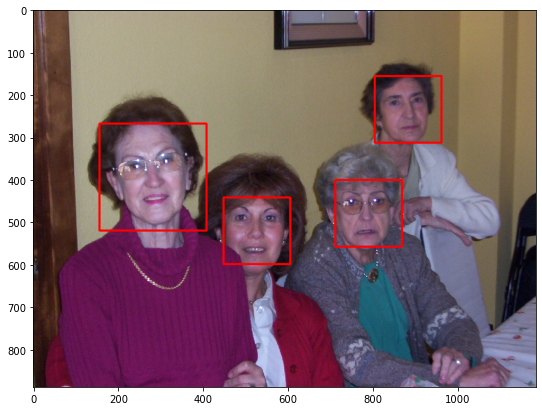

In [39]:
def CascadeFD(image_gray):
    face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
    if np.max(image_gray) < 1.1: #if the image is normalized
        image_gray = np.array(image_gray*255, dtype='uint8') #We cannot use normalized images for this algorithm.
    # load in a haar cascade classifier for detecting frontal faces
    faces = face_cascade.detectMultiScale(image_gray, 1.6, 3)
    
    return faces


#Test the function
image_copy1 = image.copy() # Create a copy image to add the rectangule
for (x,y,w,h) in CascadeFD(image_copy):
    
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_copy1,(x,y),(x+w,y+h),(255,0,0),3) 
    
fig = plt.figure(figsize=(9,9))

plt.imshow(image_copy1)


This function prepares the images for insertion into the model.

In [40]:
def normalize_fi(image_gray, faces):
    
    #Normalize values 
    if np.max(image_gray) > 1:
        image_gray = image_gray/255.0
    #reshape the faces images
    faces_im = [] 
    or_size = [] #save the original position and size to return the key points to the position
    for (x,y,w,h) in faces: # select the face area
        # define an image contour and cut the face, if the contour is negatve the line is 0
        cont_x = int(w*0.25)
        if x-cont_x < 0: cont_x = x
        cont_y = int(h*0.25)
        if y-cont_y < 0: cont_y = y
        
        or_size.append([x-cont_x, y-cont_y, w+2*cont_x, h+2*cont_y]) #original potion to the face
        
        ###Before cutting an area of the face it is necessary to erase the other faces in 
        #the image, with this the model has a better result.
        
        image_gray_copy = np.copy(image_gray) 
        
        for (ox, oy, ow, oh) in faces:                                  
            if [ox, oy, ow, oh] != [x,y,w,h]:                           #other faces position
                image_gray_copy[oy:oy+int(oh), ox:ox+int(ow)] = 0       #change the pixels in the other areas of the faces
        
        image_with_detections = image_gray_copy[y-cont_y:y+h+cont_y, x-cont_x:x+w+cont_x]   #cut the face
        image_with_detections = cv2.resize( image_with_detections,(224, 224) )              #resize the face

        
        faces_im.append( np.array([image_with_detections])  ) #save de face image
    
    return faces_im, or_size    
        

After define the function, we start the process

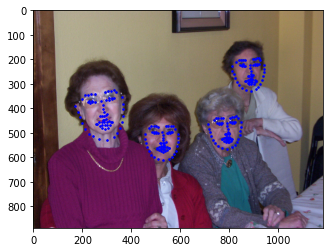

In [41]:
#obtain the faces position
faces_position = CascadeFD(image_copy)
#Normalize and resize the face images
faces_im, or_size = normalize_fi(image_copy, faces_position)

#introduce in the model
key_points = cnn(torch.tensor(faces_im).float()  )
#Remember that these key points are normalized, they need to be changed.
key_points = (key_points*50 + 100).detach().numpy()

#print the image with all key points
final_image = image.copy()
plt.imshow(final_image)
#Reshize the key points
for i in range(len(key_points)):
    kp = key_points[i]
    kp = kp.reshape(-1, 2)
    size = or_size[i]
    
    #return key points to the original position on the face
    kp[:, 0] = kp[:, 0]*size[2]/224.0 + size[0]
    kp[:, 1] = kp[:, 1]*size[3]/224.0 + size[1]
    
    plt.scatter(kp[:, 0], kp[:, 1], s=10, marker='.', c='b')
    
plt.show()
plt.close()
    
    